In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, Activation, Rescaling
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
import matplotlib.pyplot as plt
import itertools

tf.__version__

'2.14.0'

In [2]:
# Loading dataset with labels and metadata from tensorflow_datasets online
tf.random.set_seed(8)
(train_dataset, test_dataset), dataset_info = tfds.load('cifar100', split = ['train', 'test'], 
                                                                data_dir = 'content/Cifar100/', shuffle_files = True, 
                                                                as_supervised = True, with_info = True)

assert isinstance(train_dataset, tf.data.Dataset)

In [3]:
# Display some info about the dataset
image_shape = dataset_info.features["image"].shape
print(f'Shape of Images in the Dataset: \t{image_shape}')

num_classes = dataset_info.features["label"].num_classes
print(f'Number of Classes in the Dataset: \t{num_classes}')

names_of_classes = dataset_info.features["label"].names
print(f'Names of Classes in the Dataset: \t{names_of_classes}\n')

for name in names_of_classes:
    print(f'Label for class "{name}": \t\t{dataset_info.features["label"].str2int(name)}')

print(f'Total examples in Train Dataset: \t{len(train_dataset)}')
print(f'Total examples in Test Dataset: \t{len(test_dataset)}')

Shape of Images in the Dataset: 	(32, 32, 3)
Number of Classes in the Dataset: 	100
Names of Classes in the Dataset: 	['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', '

In [4]:
# Normalise image values to 0-1 from 0-255
img_normaliser = Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (img_normaliser(x), y), num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(lambda x, y: (img_normaliser(x), y), num_parallel_calls = tf.data.experimental.AUTOTUNE)

train_dataset = train_dataset.cache()
test_dataset = test_dataset.cache()
# Give length of the dataset to `shuffle` so that random samples are from any part of the dataset
train_dataset = train_dataset.shuffle(len(train_dataset))
# Get 1024 samples from the training and testing datasets
train_dataset = train_dataset.batch(2048)
test_dataset = test_dataset.batch(1024)
# Load the data in parallel with training: https://www.tensorflow.org/guide/data_performance#prefetching
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [5]:
# Building the model

# Initial input layer
input_layer = Input(shape=image_shape)

# Set of convolutional layers to process weights on the image data
model_layers = Conv2D(filters = 32, kernel_size = (3, 3), strides=2)(input_layer)
model_layers = Activation("relu")(model_layers)

model_layers = Conv2D(filters = 64, kernel_size = (3, 3), strides=2)(model_layers)
model_layers = Activation("relu")(model_layers)

model_layers = Conv2D(filters = 128, kernel_size = (3, 3), strides=2)(model_layers)
model_layers = Activation("relu")(model_layers)

# Flatten the output of the last convolutional layer to 1 dimension to allow for future dense layers to process it
# Adding dropout to help reduce overfitting
model_layers = Flatten()(model_layers)
model_layers = Dropout(rate=0.5)(model_layers)

model_layers = Dense(units=1024)(model_layers)
model_layers = Activation("relu")(model_layers)
model_layers = Dropout(rate=0.2)(model_layers)

# Output layer takes the same shape as the number of classes - predicted class will have the highest probability on its respective node
model_layers = Dense(units=num_classes)(model_layers)
output = Activation("softmax")(model_layers)

classification_model = Model(input_layer, output)

In [6]:
# Build and train the model - note that training time will be long if on CPU.
classification_model.compile(
                      optimizer='adam', loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'], loss_weights=None,
                      weighted_metrics=None, run_eagerly=None,
                      steps_per_execution=None
)

print(classification_model.summary())

history = classification_model.fit(train_dataset, validation_data=test_dataset, epochs=20)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 15, 15, 32)        896       
                                                                 
 activation (Activation)     (None, 15, 15, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 activation_1 (Activation)   (None, 7, 7, 64)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 activation_2 (Activation)   (None, 3, 3, 128)         0     

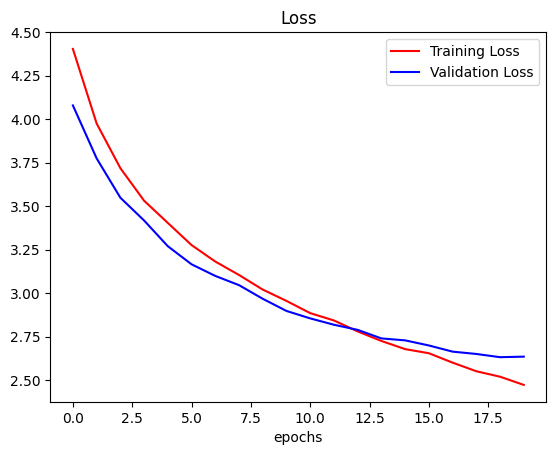

<Figure size 640x480 with 0 Axes>

In [7]:
# Generating a graph that shows the loss per epoch, by building a function that can generally show a trend on a graph
def plot_trend_by_epoch(tr_values, val_values, title):
    epoch_number = range(len(tr_values))
    plt.plot(epoch_number, tr_values, 'r')
    plt.plot(epoch_number, val_values, 'b')
    plt.title(title)
    plt.xlabel('epochs')
    plt.legend(['Training '+title, 'Validation '+title])
    plt.figure()

hist_dict = history.history
tr_loss, val_loss = hist_dict['loss'], hist_dict['val_loss']
plot_trend_by_epoch(tr_loss, val_loss, "Loss")

We can see from this graph that the training is allowing the model to adapt well to the testing set without over-fitting from the first 20 epochs

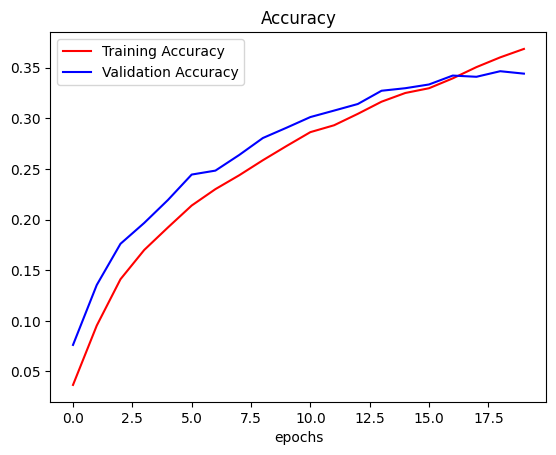

<Figure size 640x480 with 0 Axes>

In [8]:
# Reuse plotting function for model accuracy
tr_accuracy, val_accuracy = hist_dict['accuracy'], hist_dict['val_accuracy']
plot_trend_by_epoch(tr_accuracy, val_accuracy, "Accuracy")

It also trends very well towards having a higher accuracy as it learns more about the data

10/10 [==============================] - 1s 71ms/step
True label: keyboard
Predicted label: shark


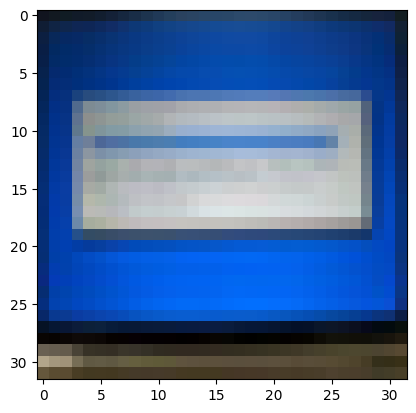

In [10]:
# Get a list of images and labels that were correct and predicted for the test dataset
test_labels = []
test_images = []

for image, label in tfds.as_numpy(test_dataset.unbatch()):
    test_images.append(image)
    test_labels.append(label)

test_labels = np.array(test_labels)
predictions = classification_model.predict(test_dataset).argmax(axis=1)

# Get the first incorrect prediction, and display the image along with the predicted and actual label
incorrect_predictions = np.where(predictions != test_labels)[0]

index = np.random.choice(incorrect_predictions)
plt.imshow(test_images[index])

print(f'True label: {names_of_classes[test_labels[index]]}')
print(f'Predicted label: {names_of_classes[predictions[index]]}')